## Generate a PSD plot framework for future plots (this one is based on our first buoy experiment).

In [1]:
#Purisa Jasmine Simmons
#August 2018

#Overview: PSD for E3 (Buoy_Calibrator1), trying to generate a PSD plot (framework for future plots).
#Based on Method V of this paper: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

#First, parse the data from the .CSV file.
#This data comes from a controlled experiment (CE3), so we are assuming that 
#all of the vertical accelerations are contained in IMUA2.

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import mpld3
import folium
import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)

In [58]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    



In [59]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)


https://surf.smartfin.org/ride/14827
https://surf.smartfin.org/media/201807/google_117589279598321562176_000666D321BE_180723164430_Ocean.CSV
                               Time  Temperature 1  Calibrated Temperature 1  \
UTC                                                                            
2018-07-23 16:44:42.467  1370665472            493                    30.812   
2018-07-23 16:44:48.487  1370671492            496                    31.000   
2018-07-23 16:44:54.507  1370677512            499                    31.188   
2018-07-23 16:45:00.528  1370683533            500                    31.250   
2018-07-23 16:45:06.549  1370689554            500                    31.250   
2018-07-23 16:45:12.569  1370695574            502                    31.375   
2018-07-23 16:45:18.591  1370701596            502                    31.375   
2018-07-23 16:45:24.612  1370707617            504                    31.500   
2018-07-23 16:45:30.634  1370713639            505         

## Make a copy of the original motion_df dataframe

In [60]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
14827   2018-07-23 16:44:42.915  1.370666e+09   138.0  -380.0   333.0 -1115.0   
        2018-07-23 16:44:42.948  1.370666e+09   181.0  -459.0   225.0  -720.0   
        2018-07-23 16:44:42.981  1.370666e+09   108.0  -446.0   291.0  -976.0   
        2018-07-23 16:44:43.014  1.370666e+09   133.0  -401.0   275.0  -558.0   
        2018-07-23 16:44:43.047  1.370666e+09   153.0  -415.0   101.0  -799.0   
        2018-07-23 16:44:43.080  1.370666e+09    46.0  -435.0   307.0  -760.0   
        2018-07-23 16:44:43.113  1.370666e+09   243.0  -324.0   412.0  -247.0   
        2018-07-23 16:44:43.146  1.370666e+09   281.0  -382.0   311.0   -69.0   
        2018-07-23 16:44:43.179  1.370666e+09   217.0  -412.0   135.0   323.0   
        2018-07-23 16:44:43.212  1.370666e+09   341.0  -546.0    56.0   190.0   
        2018-07-23 16:44:43.

## Calcualting time_elapseds, time_offsets and creating IMU1, IMU2, and IMU3 raw data lists

In [67]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3'])

#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []

imu1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array1 = []

imu2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array2 = []

imu3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array3 = []


#Get all the times and imus where time, imu1, imu2, and imu3 are NOT nan values:
for t,x,y,z in zip(time_array_nans, imu1_array_nans, imu2_array_nans, imu3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array1.append(x)
        imu_array2.append(y)
        imu_array3.append(z)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    
    #print(prev, " ", after)
    #print(after - prev)
    
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1


##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array1[-1])
del(imu_array2[-1])
del(imu_array3[-1])
    
print(len(time_e_list))
print(len(time_o_list))
print(len(imu_array1))
print(len(imu_array2))
print(len(imu_array3))





23432
23432
23432
23432
23432


## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

17.0850230469 -380.0
18.5981584961 -459.0
18.3491615234 -446.0
17.4872489258 -401.0
17.7553995117 -415.0
18.1384717773 -435.0
16.0124207031 -324.0
17.1233302734 -382.0
17.6979386719 -412.0
20.2645228516 -546.0
20.3028300781 -548.0
19.2876885742 -495.0
16.9317941406 -372.0
14.8248966797 -262.0
16.4912610352 -349.0
16.2422640625 -336.0
17.5638633789 -405.0
18.1001645508 -433.0
17.6979386719 -412.0
16.682797168 -359.0
17.3723272461 -395.0
17.8128603516 -418.0
16.3188785156 -340.0
16.2039568359 -334.0
16.548721875 -352.0
16.7019507812 -360.0
17.2574055664 -389.0
17.0850230469 -380.0
17.3531736328 -394.0
17.0658694336 -379.0
16.4912610352 -349.0
16.6061827148 -355.0
16.3954929687 -344.0
16.7977188477 -365.0
15.9932670898 -323.0
15.4378123047 -294.0
15.0547400391 -274.0
17.2765591797 -390.0
17.3340200195 -393.0
14.3077491211 -235.0
13.350068457 -185.0
15.1696617187 -280.0
16.1464959961 -331.0
16.4338001953 -346.0
16.6061827148 -355.0
16.1273423828 -330.0
16.069881543 -327.0
15.7442701172 -31

9.73003554687 4.0
9.78749638672 1.0
9.94072529297 -7.0
9.86411083984 -3.0
9.80665 0.0
9.82580361328 -1.0
9.36611689453 23.0
9.63426748047 9.0
9.71088193359 5.0
9.57680664062 12.0
9.97903251953 -9.0
9.73003554687 4.0
9.73003554687 4.0
9.95987890625 -8.0
9.73003554687 4.0
9.80665 0.0
9.57680664062 12.0
9.76834277344 2.0
9.76834277344 2.0
9.69172832031 6.0
9.73003554687 4.0
9.78749638672 1.0
9.76834277344 2.0
9.82580361328 -1.0
9.67257470703 7.0
9.74918916016 3.0
9.73003554687 4.0
9.73003554687 4.0
9.71088193359 5.0
9.76834277344 2.0
9.71088193359 5.0
9.73003554687 4.0
9.76834277344 2.0
9.74918916016 3.0
9.80665 0.0
9.73003554687 4.0
9.94072529297 -7.0
10.1131078125 -16.0
9.65342109375 8.0
9.73003554687 4.0
9.82580361328 -1.0
9.73003554687 4.0
9.84495722656 -2.0
9.69172832031 6.0
10.2663367187 -24.0
9.63426748047 9.0
9.73003554687 4.0
9.82580361328 -1.0
9.78749638672 1.0
9.76834277344 2.0
9.67257470703 7.0
9.57680664062 12.0
9.80665 0.0
9.73003554687 4.0
9.74918916016 3.0
9.78749638672 1.

9.34696328125 24.0
9.53849941406 14.0
9.46188496094 18.0
9.46188496094 18.0
9.61511386719 10.0
9.42357773437 20.0
9.67257470703 7.0
9.42357773437 20.0
9.51934580078 15.0
9.48103857422 17.0
9.32780966797 25.0
9.55765302734 13.0
9.5001921875 16.0
9.42357773437 20.0
9.44273134766 19.0
9.5001921875 16.0
9.61511386719 10.0
9.55765302734 13.0
9.42357773437 20.0
9.44273134766 19.0
9.46188496094 18.0
9.44273134766 19.0
9.71088193359 5.0
9.48103857422 17.0
9.40442412109 21.0
9.90241806641 -5.0
9.27034882812 28.0
9.53849941406 14.0
9.53849941406 14.0
9.73003554687 4.0
9.51934580078 15.0
9.48103857422 17.0
9.44273134766 19.0
9.51934580078 15.0
9.32780966797 25.0
9.69172832031 6.0
9.30865605469 26.0
9.67257470703 7.0
9.57680664062 12.0
9.46188496094 18.0
9.5001921875 16.0
9.48103857422 17.0
9.59596025391 11.0
9.193734375 32.0
9.30865605469 26.0
9.5001921875 16.0
9.46188496094 18.0
9.51934580078 15.0
9.55765302734 13.0
9.65342109375 8.0
9.42357773437 20.0
9.80665 0.0
9.17458076172 33.0
9.8832644531

9.63426748047 9.0
10.7451770508 -49.0
10.7643306641 -50.0
11.0899420898 -67.0
11.4730143555 -87.0
11.3389390625 -80.0
11.3006318359 -78.0
10.8792523438 -56.0
10.7260234375 -48.0
10.1131078125 -16.0
9.92157167969 -6.0
10.0939541992 -15.0
10.5823713379 -40.5
10.2471831055 -23.0
10.0748005859 -14.0
8.77235488281 54.0
9.21288798828 31.0
9.88326445312 -4.0
7.64229169922 113.0
10.7451770508 -49.0
8.54251152344 66.0
7.52737001953 119.0
7.56567724609 117.0
7.27837304688 132.0
7.37414111328 127.0
6.79953271484 157.0
5.95677373047 201.0
6.33984599609 181.0
7.01022246094 146.0
6.99106884766 147.0
7.37414111328 127.0
7.3549875 128.0
7.85298144531 102.0
8.14028564453 87.0
7.77636699219 106.0
7.91044228516 99.0
7.6614453125 112.0
7.64229169922 113.0
7.20175859375 136.0
7.06768330078 143.0
7.08683691406 142.0
6.72291826172 161.0
6.79953271484 157.0
6.45476767578 175.0
5.89931289062 204.0
6.09084902344 194.0
6.83783994141 155.0
6.99106884766 147.0
6.76122548828 159.0
6.97191523437 148.0
7.29752666016 

6.81868632812 156.0
5.32470449219 234.0
4.27125576172 289.0
4.48194550781 278.0
5.26724365234 237.0
6.45476767578 175.0
7.46990917969 122.0
6.93360800781 150.0
6.81868632812 156.0
6.83783994141 155.0
7.14429775391 139.0
7.6614453125 112.0
7.94874951172 97.0
8.12113203125 88.0
7.81467421875 104.0
7.20175859375 136.0
6.20577070312 188.0
4.99909306641 251.0
5.17147558594 242.0
5.49708701172 225.0
5.47793339844 226.0
4.75009609375 264.0
4.46279189453 279.0
4.92247861328 255.0
5.68862314453 215.0
6.22492431641 187.0
6.76122548828 159.0
7.52737001953 119.0
8.08282480469 90.0
8.19774648437 84.0
8.12113203125 88.0
7.81467421875 104.0
7.16345136719 138.0
6.79953271484 157.0
6.20577070312 188.0
5.74608398437 212.0
5.80354482422 209.0
5.59285507812 220.0
5.89931289062 204.0
6.4356140625 176.0
6.45476767578 175.0
6.87614716797 153.0
6.87614716797 153.0
6.79953271484 157.0
7.43160195312 124.0
7.73805976562 108.0
7.87213505859 101.0
7.81467421875 104.0
7.87213505859 101.0
7.85298144531 102.0
7.27837

9.05965908203 39.0
8.73404765625 56.0
8.69574042969 58.0
8.29351455078 79.0
8.08282480469 90.0
7.98705673828 95.0
8.25520732422 81.0
8.40843623047 73.0
8.25520732422 81.0
8.65743320312 60.0
8.42758984375 72.0
8.56166513672 65.0
8.19774648437 84.0
7.91044228516 99.0
7.92959589844 98.0
7.89128867187 100.0
7.6614453125 112.0
7.6614453125 112.0
7.85298144531 102.0
7.98705673828 95.0
8.31266816406 78.0
8.56166513672 65.0
8.48505068359 69.0
8.25520732422 81.0
8.15943925781 86.0
8.04451757812 92.0
8.08282480469 90.0
8.25520732422 81.0
8.33182177734 77.0
8.40843623047 73.0
8.52335791016 67.0
8.54251152344 66.0
8.65743320312 60.0
8.71489404297 57.0
8.58081875 64.0
8.52335791016 67.0
8.37012900391 75.0
8.35097539062 76.0
8.38928261719 74.0
8.56166513672 65.0
8.69574042969 58.0
8.77235488281 54.0
8.73404765625 56.0
8.82981572266 51.0
8.63827958984 61.0
8.54251152344 66.0
8.25520732422 81.0
8.14028564453 87.0
7.89128867187 100.0
8.02536396484 93.0
8.29351455078 79.0
8.33182177734 77.0
8.4275898437

0.172382519531 503.0
0.0191536132813 511.0
0.0383072265625 510.0
-0.0191536132813 513.0
0.0383072265625 510.0
0.287304199219 497.0
0.287304199219 497.0
0.191536132812 502.0
0.15322890625 504.0
0.248996972656 499.0
0.344765039062 494.0
0.268150585937 498.0
0.325611425781 495.0
0.229843359375 500.0
0.210689746094 501.0
0.172382519531 503.0
0.191536132812 502.0
0.248996972656 499.0
0.268150585937 498.0
0.325611425781 495.0
0.363918652344 493.0
0.383072265625 492.0
0.268150585937 498.0
0.210689746094 501.0
0.3064578125 496.0
0.383072265625 492.0
0.325611425781 495.0
0.344765039062 494.0
0.210689746094 501.0
0.172382519531 503.0
0.0383072265625 510.0
0.134075292969 505.0
0.229843359375 500.0
0.45968671875 488.0
0.421379492187 490.0
0.383072265625 492.0
0.344765039062 494.0
0.383072265625 492.0
0.325611425781 495.0
0.15322890625 504.0
0.0574608398438 509.0
0.114921679687 506.0
0.114921679687 506.0
0.0574608398438 509.0
0.191536132812 502.0
0.268150585937 498.0
0.229843359375 500.0
0.30645781

0.287304199219 497.0
0.229843359375 500.0
0.3064578125 496.0
0.210689746094 501.0
0.268150585937 498.0
-0.0957680664063 517.0
-2.48996972656 642.0
-0.344765039062 530.0
-0.0383072265625 514.0
1.11090957031 454.0
0.593762011719 481.0
-0.593762011719 543.0
-0.172382519531 521.0
1.28329208984 445.0
-0.210689746094 523.0
-0.0383072265625 514.0
0.976834277344 461.0
0.976834277344 461.0
0.478840332031 487.0
0.689530078125 476.0
0.689530078125 476.0
0.612915625 480.0
0.497993945312 486.0
0.45968671875 488.0
0.517147558594 485.0
0.383072265625 492.0
0.344765039062 494.0
1.30244570313 444.0
2.10689746094 402.0
1.66636435547 425.0
2.01112939453 407.0
1.45567460938 436.0
3.35188232422 337.0
5.09486113281 246.0
4.73094248047 265.0
5.84185205078 207.0
5.97592734375 200.0
5.09486113281 246.0
4.86501777344 258.0
4.290409375 288.0
3.67749375 320.0
2.81558115234 365.0
2.29843359375 392.0
1.39821376953 439.0
0.804451757812 470.0
0.191536132812 502.0
0.3064578125 496.0
0.114921679687 506.0
-0.13407529296

-2.22181914062 628.0
-1.93451494141 613.0
-1.99197578125 616.0
-1.5322890625 592.0
-1.47482822266 589.0
-0.9193734375 560.0
-1.22583125 576.0
-0.421379492187 534.0
-0.536301171875 540.0
-0.363918652344 531.0
-0.708683691406 549.0
-0.497993945312 538.0
-0.497993945312 538.0
-0.114921679687 518.0
-0.0957680664063 517.0
-0.114921679687 518.0
-0.0191536132813 513.0
0.0957680664063 507.0
0.0957680664063 507.0
0.248996972656 499.0
0.3064578125 496.0
0.0574608398438 509.0
0.0191536132813 511.0
0.191536132812 502.0
0.191536132812 502.0
0.210689746094 501.0
0.229843359375 500.0
0.497993945312 486.0
0.593762011719 481.0
0.746990917969 473.0
0.746990917969 473.0
1.03429511719 458.0
0.746990917969 473.0
0.823605371094 469.0
0.383072265625 492.0
-0.172382519531 521.0
-0.785298144531 553.0
-0.976834277344 563.0
-0.938527050781 561.0
-0.574608398437 542.0
-0.45968671875 536.0
-0.402225878906 533.0
-0.287304199219 527.0
-0.287304199219 527.0
-0.0574608398438 515.0
0.15322890625 504.0
0.689530078125 47

1.70467158203 423.0
1.91536132812 412.0
1.78128603516 419.0
1.35990654297 441.0
0.76614453125 472.0
0.134075292969 505.0
0.3064578125 496.0
0.881066210937 466.0
1.43652099609 437.0
2.06859023437 404.0
2.37504804687 388.0
2.43250888672 385.0
2.26012636719 394.0
2.08774384766 403.0
1.93451494141 411.0
1.838746875 416.0
1.80043964844 418.0
1.81959326172 417.0
1.76213242188 420.0
1.78128603516 419.0
1.85790048828 415.0
1.68551796875 424.0
1.66636435547 425.0
1.4844050293 434.5
1.05344873047 457.0
0.708683691406 475.0
0.593762011719 481.0
0.670376464844 477.0
0.900219824219 465.0
1.07260234375 456.0
0.612915625 480.0
0.497993945312 486.0
0.287304199219 497.0
-0.0383072265625 514.0
-0.402225878906 533.0
-0.612915625 544.0
-0.670376464844 547.0
-0.651222851562 546.0
-0.383072265625 532.0
0.0574608398438 509.0
-0.402225878906 533.0
-0.632069238281 545.0
-1.24498486328 577.0
-1.37906015625 584.0
-0.076614453125 516.0
2.1452046875 400.0
1.74297880859 421.0
1.93451494141 411.0
1.51313544922 433.0

0.45968671875 488.0
0.344765039062 494.0
0.497993945312 486.0
0.536301171875 484.0
0.517147558594 485.0
0.593762011719 481.0
0.670376464844 477.0
0.536301171875 484.0
0.45968671875 488.0
0.383072265625 492.0
0.402225878906 491.0
0.248996972656 499.0
0.3064578125 496.0
0.191536132812 502.0
0.229843359375 500.0
0.0957680664063 507.0
0.229843359375 500.0
0.172382519531 503.0
0.0957680664063 507.0
0.172382519531 503.0
0.134075292969 505.0
0.172382519531 503.0
0.287304199219 497.0
0.191536132812 502.0
0.248996972656 499.0
0.325611425781 495.0
0.268150585937 498.0
0.325611425781 495.0
0.45968671875 488.0
0.45968671875 488.0
0.440533105469 489.0
0.45968671875 488.0
0.363918652344 493.0
0.497993945312 486.0
0.344765039062 494.0
0.344765039062 494.0
0.363918652344 493.0
0.3064578125 496.0
0.325611425781 495.0
0.268150585937 498.0
0.248996972656 499.0
0.3064578125 496.0
0.229843359375 500.0
0.134075292969 505.0
0.287304199219 497.0
0.210689746094 501.0
0.210689746094 501.0
0.210689746094 501.0
0

1.78128603516 419.0
1.87705410156 414.0
2.22181914062 396.0
1.60890351563 428.0
0.881066210937 466.0
0.976834277344 461.0
0.536301171875 484.0
0.210689746094 501.0
0.555454785156 483.0
0.76614453125 472.0
1.14921679688 452.0
1.14921679688 452.0
1.76213242188 420.0
2.08774384766 403.0
1.99197578125 408.0
2.31758720703 391.0
2.12605107422 401.0
1.64721074219 426.0
1.95366855469 410.0
1.57059628906 430.0
2.27927998047 393.0
3.064578125 352.0
2.89219560547 361.0
3.064578125 352.0
3.69664736328 319.0
3.40934316406 334.0
3.62003291016 323.0
3.58172568359 325.0
3.71580097656 318.0
3.39018955078 335.0
3.56257207031 326.0
2.87304199219 362.0
2.83473476562 364.0
2.52827695313 380.0
2.66235224609 373.0
2.27927998047 393.0
1.93451494141 411.0
0.881066210937 466.0
1.64721074219 426.0
1.51313544922 433.0
1.11090957031 454.0
0.881066210937 466.0
0.45968671875 488.0
0.076614453125 508.0
0.0191536132813 511.0
0.172382519531 503.0
-0.0574608398438 515.0
0.344765039062 494.0
0.440533105469 489.0
1.225831

0.268150585937 498.0
0.363918652344 493.0
0.440533105469 489.0
0.325611425781 495.0
0.383072265625 492.0
0.383072265625 492.0
0.248996972656 499.0
0.210689746094 501.0
0.210689746094 501.0
0.134075292969 505.0
0.191536132812 502.0
0.172382519531 503.0
0.134075292969 505.0
0.172382519531 503.0
0.15322890625 504.0
0.15322890625 504.0
0.191536132812 502.0
0.248996972656 499.0
0.268150585937 498.0
0.344765039062 494.0
0.325611425781 495.0
0.287304199219 497.0
0.325611425781 495.0
0.229843359375 500.0
0.402225878906 491.0
0.402225878906 491.0
0.402225878906 491.0
0.363918652344 493.0
0.402225878906 491.0
0.45968671875 488.0
0.325611425781 495.0
0.3064578125 496.0
0.287304199219 497.0
0.3064578125 496.0
0.248996972656 499.0
0.229843359375 500.0
0.344765039062 494.0
0.210689746094 501.0
0.172382519531 503.0
0.210689746094 501.0
0.210689746094 501.0
0.0957680664063 507.0
0.172382519531 503.0
0.287304199219 497.0
0.268150585937 498.0
0.172382519531 503.0
0.363918652344 493.0
0.3064578125 496.0


0.287304199219 497.0
0.0957680664063 507.0
0.248996972656 499.0
0.248996972656 499.0
0.210689746094 501.0
0.3064578125 496.0
-0.0957680664063 517.0
-0.746990917969 551.0
-1.13006318359 571.0
-1.34075292969 582.0
-0.76614453125 552.0
-0.076614453125 516.0
0.976834277344 461.0
2.06859023437 404.0
0.785298144531 471.0
0.76614453125 472.0
1.51313544922 433.0
1.32159931641 443.0
1.35990654297 441.0
1.89620771484 413.0
1.66636435547 425.0
0.900219824219 465.0
0.3064578125 496.0
1.07260234375 456.0
-0.172382519531 521.0
-0.363918652344 531.0
-0.804451757812 554.0
-1.74297880859 603.0
-1.32159931641 581.0
-0.248996972656 525.0
0.344765039062 494.0
0.3064578125 496.0
0.15322890625 504.0
0.478840332031 487.0
0.383072265625 492.0
0.191536132812 502.0
0.3064578125 496.0
0.229843359375 500.0
0.363918652344 493.0
0.383072265625 492.0
0.268150585937 498.0
0.0574608398438 509.0
0.114921679687 506.0
-0.210689746094 523.0
0.497993945312 486.0
0.248996972656 499.0
0.210689746094 501.0
-0.0191536132813 51

0.363918652344 493.0
0.344765039062 494.0
0.363918652344 493.0
0.248996972656 499.0
0.268150585937 498.0
0.248996972656 499.0
0.201112939453 501.5
0.114921679687 506.0
0.0383072265625 510.0
0.076614453125 508.0
0.172382519531 503.0
0.210689746094 501.0
0.210689746094 501.0
0.287304199219 497.0
0.363918652344 493.0
0.268150585937 498.0
0.325611425781 495.0
0.287304199219 497.0
0.191536132812 502.0
0.172382519531 503.0
0.248996972656 499.0
0.191536132812 502.0
0.0574608398438 509.0
-0.325611425781 529.0
-0.785298144531 553.0
-1.37906015625 584.0
-1.78128603516 605.0
-1.87705410156 610.0
-1.93451494141 613.0
-2.27927998047 631.0
-2.33674082031 634.0
-2.18351191406 626.0
-2.16435830078 625.0
-2.18351191406 626.0
-2.22181914062 628.0
-1.97282216797 615.0
-2.12605107422 623.0
-1.22583125 576.0
-1.13006318359 571.0
-0.344765039062 530.0
-0.076614453125 516.0
0.287304199219 497.0
0.478840332031 487.0
0.708683691406 475.0
0.842758984375 468.0
0.842758984375 468.0
1.13963999023 452.5
1.436520996

0.363918652344 493.0
0.45968671875 488.0
0.497993945312 486.0
0.344765039062 494.0
0.45968671875 488.0
0.325611425781 495.0
0.268150585937 498.0
0.210689746094 501.0
0.325611425781 495.0
0.15322890625 504.0
0.172382519531 503.0
0.287304199219 497.0
0.268150585937 498.0
0.268150585937 498.0
0.248996972656 499.0
0.191536132812 502.0
0.287304199219 497.0
0.191536132812 502.0
0.15322890625 504.0
0.0957680664063 507.0
0.287304199219 497.0
0.248996972656 499.0
0.134075292969 505.0
0.248996972656 499.0
0.363918652344 493.0
0.325611425781 495.0
0.268150585937 498.0
0.210689746094 501.0
0.287304199219 497.0
0.287304199219 497.0
0.134075292969 505.0
0.248996972656 499.0
0.268150585937 498.0
0.287304199219 497.0
0.344765039062 494.0
0.210689746094 501.0
0.15322890625 504.0
0.325611425781 495.0
0.287304199219 497.0
0.134075292969 505.0
0.210689746094 501.0
0.287304199219 497.0
0.191536132812 502.0
0.191536132812 502.0
0.248996972656 499.0
0.229843359375 500.0
0.134075292969 505.0
0.15322890625 504

0.248996972656 499.0
0.287304199219 497.0
0.402225878906 491.0
0.325611425781 495.0
0.076614453125 508.0
0.229843359375 500.0
0.248996972656 499.0
0.172382519531 503.0
0.268150585937 498.0
0.325611425781 495.0
0.15322890625 504.0
-0.0383072265625 514.0
-0.0383072265625 514.0
-0.114921679687 518.0
0.076614453125 508.0
0.574608398437 482.0
0.612915625 480.0
0.478840332031 487.0
0.497993945312 486.0
0.0383072265625 510.0
-0.134075292969 519.0
-0.0383072265625 514.0
0.210689746094 501.0
0.268150585937 498.0
0.402225878906 491.0
0.517147558594 485.0
0.555454785156 483.0
0.402225878906 491.0
0.191536132812 502.0
0.325611425781 495.0
0.287304199219 497.0
0.191536132812 502.0
0.325611425781 495.0
0.402225878906 491.0
0.210689746094 501.0
0.287304199219 497.0
0.3064578125 496.0
0.210689746094 501.0
0.210689746094 501.0
0.0383072265625 510.0
0.229843359375 500.0
0.363918652344 493.0
0.440533105469 489.0
0.383072265625 492.0
0.344765039062 494.0
0.268150585937 498.0
0.15322890625 504.0
0.24899697

8.63827958984 61.0
8.56166513672 65.0
8.50420429687 68.0
8.19774648437 84.0
8.17859287109 85.0
8.14028564453 87.0
8.21690009766 83.0
8.46589707031 70.0
8.04451757812 92.0
8.21690009766 83.0
8.25520732422 81.0
8.06367119141 91.0
8.23605371094 82.0
8.42758984375 72.0
8.2743609375 80.0
8.23605371094 82.0
8.56166513672 65.0
8.75320126953 55.0
8.50420429687 68.0
8.73404765625 56.0
8.75320126953 55.0
8.69574042969 58.0
8.75320126953 55.0
8.56166513672 65.0
8.67658681641 59.0
8.50420429687 68.0
8.14028564453 87.0
8.56166513672 65.0
8.25520732422 81.0
8.63827958984 61.0
8.8872765625 48.0
9.11711992188 36.0
9.42357773437 20.0
9.44273134766 19.0
9.97903251953 -9.0
10.2280294922 -22.0
10.7260234375 -48.0
10.9941740234 -62.0
10.7260234375 -48.0
10.6494089844 -44.0
10.4961800781 -36.0
10.5153336914 -37.0
10.5344873047 -38.0
10.5344873047 -38.0
10.4770264648 -35.0
10.1514150391 -18.0
10.0556469727 -13.0
9.86411083984 -3.0
9.78749638672 1.0
9.51934580078 15.0
9.05965908203 39.0
8.75320126953 55.0
8.3

9.32780966797 25.0
9.99818613281 -10.0
10.5919481445 -41.0
10.7834842773 -51.0
10.8600987305 -55.0
10.5153336914 -37.0
10.4387192383 -33.0
9.86411083984 -3.0
9.21288798828 31.0
9.00219824219 42.0
9.00219824219 42.0
8.8872765625 48.0
8.67658681641 59.0
9.23204160156 30.0
8.58081875 64.0
8.56166513672 65.0
8.96389101563 44.0
8.46589707031 70.0
8.73404765625 56.0
10.3046439453 -26.0
10.2663367187 -24.0
9.80665 0.0
9.76834277344 2.0
9.57680664062 12.0
9.67257470703 7.0
9.51934580078 15.0
9.23204160156 30.0
9.40442412109 21.0
9.21288798828 31.0
9.13627353516 35.0
9.11711992188 36.0
8.65743320312 60.0
8.81066210937 52.0
9.05965908203 39.0
9.28950244141 27.0
9.59596025391 11.0
9.30865605469 26.0
9.53849941406 14.0
10.3046439453 -26.0
9.97903251953 -9.0
10.1322614258 -17.0
10.3429511719 -28.0
10.2088758789 -21.0
9.55765302734 13.0
9.07881269531 38.0
9.42357773437 20.0
8.44674345703 71.0
8.67658681641 59.0
9.13627353516 35.0
8.98304462891 43.0
8.84896933594 50.0
9.46188496094 18.0
9.73003554687

10.2471831055 -23.0
10.419565625 -32.0
10.419565625 -32.0
10.1514150391 -18.0
9.86411083984 -3.0
10.285490332 -25.0
10.5344873047 -38.0
11.2048637695 -73.0
11.0516348633 -65.0
10.7260234375 -48.0
10.0939541992 -15.0
10.0748005859 -14.0
10.8600987305 -55.0
11.1282493164 -69.0
10.7260234375 -48.0
10.3812583984 -30.0
10.5153336914 -37.0
10.6111017578 -42.0
10.6494089844 -44.0
10.5919481445 -41.0
10.6494089844 -44.0
10.7068698242 -47.0
11.1474029297 -70.0
11.4921679687 -88.0
11.5687824219 -92.0
11.4347071289 -85.0
11.0707884766 -66.0
10.9750204102 -61.0
11.1282493164 -69.0
11.4538607422 -86.0
12.0284691406 -116.0
11.4347071289 -85.0
10.285490332 -25.0
10.3429511719 -28.0
10.8409451172 -54.0
10.8600987305 -55.0
10.1705686523 -19.0
10.1514150391 -18.0
10.1131078125 -16.0
10.0364933594 -12.0
10.2088758789 -21.0
10.7451770508 -49.0
10.8600987305 -55.0
10.4770264648 -35.0
9.84495722656 -2.0
9.97903251953 -9.0
10.4387192383 -33.0
10.6685625977 -45.0
10.8600987305 -55.0
10.6494089844 -44.0
10.572

10.7260234375 -48.0
10.8409451172 -54.0
10.6494089844 -44.0
10.6685625977 -45.0
10.4961800781 -36.0
10.7260234375 -48.0
10.6877162109 -46.0
10.8600987305 -55.0
10.8026378906 -52.0
13.1202250977 -173.0
9.55765302734 13.0
7.52737001953 119.0
10.6877162109 -46.0
10.9558667969 -60.0
11.2814782227 -77.0
10.0173397461 -11.0
11.2048637695 -73.0
10.5919481445 -41.0
10.4578728516 -34.0
10.1131078125 -16.0
10.0939541992 -15.0
10.3046439453 -26.0
10.5344873047 -38.0
10.7643306641 -50.0
9.25119521484 29.0
10.4004120117 -31.0
10.2471831055 -23.0
10.1514150391 -18.0
10.5344873047 -38.0
10.4004120117 -31.0
10.6494089844 -44.0
10.3429511719 -28.0
10.2471831055 -23.0
10.7451770508 -49.0
10.4578728516 -34.0
10.419565625 -32.0
10.6685625977 -45.0
11.03248125 -64.0
10.419565625 -32.0
10.0556469727 -13.0
10.3046439453 -26.0
10.8026378906 -52.0
10.7260234375 -48.0
10.3812583984 -30.0
9.44273134766 19.0
10.6877162109 -46.0
10.4770264648 -35.0
10.3046439453 -26.0
9.97903251953 -9.0
10.6877162109 -46.0
11.7794

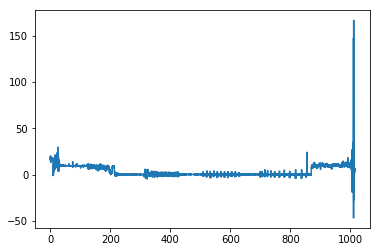

Why are the y-axis values so small?


In [68]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])


#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = -9.80665

# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity - gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2

##To check:
for x,y in zip(imu2_array, imu_array2):
    print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
print(len(time_e_list))
print(len(imu2_array))

plt.plot(time_e_array, imu2_array)
plt.show()

print("Why are the y-axis values so small?")

## PSD Step 1: Seperate each of the subexperiments into its own acc lists

In [69]:
for x in time_e_array:
    print(x)

0.0
0.033
0.066
0.099
0.132
0.165
0.198
0.231
0.265
0.297
0.331
0.364
0.397
0.43
0.463
0.496
0.529
0.563
0.595
0.629
0.662
0.695
0.728
0.761
0.794
0.827
0.861
0.893
0.926
0.96
0.993
1.026
1.059
1.092
1.125
1.159
1.191
1.224
1.258
1.291
1.324
1.357
1.39
1.423
1.456
1.489
1.523
1.555
1.589
1.622
1.655
1.688
1.721
1.754
1.787
1.821
1.853
1.887
1.92
1.953
1.986
2.019
2.052
2.085
2.119
2.151
2.184
2.218
2.251
2.284
2.317
2.35
2.383
2.416
2.449
2.482
2.515
2.549
2.582
2.615
2.648
2.681
2.714
2.747
2.78
2.813
2.846
2.88
2.913
2.946
2.979
3.012
3.045
3.079
3.111
3.144
3.178
3.211
3.244
3.277
3.31
3.343
3.376
3.409
3.443
3.475
3.498
3.531
3.564
3.597
3.63
3.663
3.696
3.729
3.762
3.795
3.829
3.862
3.895
3.928
3.961
3.994
4.027
4.06
4.093
4.127
4.16
4.193
4.226
4.259
4.292
4.325
4.359
4.391
4.424
4.458
4.491
4.524
4.557
4.59
4.623
4.656
4.689
4.723
4.755
4.789
4.822
4.855
4.888
4.921
4.954
4.987
5.02
5.053
5.087
5.12
5.153
5.186
5.219
5.252
5.285
5.319
5.351
5.385
5.417
5.451
5.484
5.517
5.568
5.

84.098
84.131
84.164
84.197
84.231
84.263
84.296
84.33
84.363
84.396
84.429
84.462
84.495
84.528
84.561
84.594
84.627
84.661
84.694
84.727
84.76
84.793
84.826
84.859
84.892
84.925
84.959
84.992
85.025
85.058
85.091
85.124
85.157
85.19
85.223
85.257
85.289
85.323
85.356
85.389
85.422
85.455
85.488
85.521
85.555
85.587
85.621
85.654
85.687
85.72
85.753
85.786
85.819
85.852
85.885
85.919
85.952
85.985
86.018
86.051
86.084
86.117
86.15
86.183
86.2275
86.272
86.305
86.338
86.371
86.404
86.437
86.47
86.503
86.537
86.569
86.603
86.636
86.669
86.702
86.735
86.768
86.801
86.834
86.867
86.901
86.934
86.967
87.0
87.033
87.066
87.099
87.132
87.165
87.199
87.232
87.265
87.298
87.331
87.364
87.397
87.43
87.463
87.497
87.529
87.563
87.596
87.629
87.662
87.695
87.728
87.761
87.795
87.827
87.861
87.894
87.927
87.96
87.993
88.026
88.059
88.093
88.125
88.158
88.192
88.225
88.258
88.291
88.324
88.357
88.391
88.423
88.456
88.49
88.523
88.556
88.589
88.622
88.655
88.688
88.721
88.755
88.787
88.821
88.854
88

178.05
178.083
178.116
178.149
178.183
178.215
178.248
178.282
178.315
178.348
178.381
178.414
178.447
178.48
178.513
178.546
178.579
178.613
178.646
178.679
178.712
178.745
178.778
178.811
178.844
178.877
178.911
178.944
178.977
179.01
179.043
179.076
179.109
179.143
179.175
179.208
179.242
179.275
179.308
179.341
179.374
179.407
179.44
179.473
179.507
179.539
179.573
179.606
179.639
179.672
179.705
179.738
179.771
179.805
179.837
179.87
179.903
179.936
179.969
180.002
180.035
180.068
180.101
180.134
180.164
180.197
180.23
180.263
180.297
180.329
180.363
180.396
180.429
180.462
180.495
180.528
180.561
180.595
180.627
180.661
180.694
180.727
180.76
180.793
180.826
180.859
180.893
180.925
180.958
180.992
181.025
181.058
181.091
181.124
181.157
181.191
181.223
181.2675
181.312
181.345
181.378
181.411
181.444
181.477
181.511
181.543
181.576
181.61
181.643
181.676
181.709
181.742
181.775
181.808
181.841
181.874
181.907
181.941
181.974
182.007
182.04
182.073
182.106
182.139
182.189
182.238


284.691
284.725
284.758
284.791
284.824
284.857
284.89
284.923
284.957
284.989
285.023
285.045
285.078
285.111
285.144
285.177
285.21
285.243
285.276
285.309
285.343
285.376
285.409
285.442
285.475
285.508
285.541
285.574
285.607
285.641
285.673
285.707
285.74
285.773
285.806
285.839
285.872
285.905
285.939
285.971
286.005
286.038
286.071
286.104
286.137
286.17
286.203
286.237
286.269
286.302
286.336
286.369
286.402
286.435
286.468
286.501
286.534
286.733
286.931
287.13
287.34
287.539
287.737
287.936
288.135
288.333
288.54
288.739
288.937
289.136
289.335
289.533
289.732
289.931
290.14
290.339
290.537
290.736
290.935
291.133
291.332
291.531
291.741
291.939
292.137
292.336
292.535
292.733
292.932
293.131
293.34
293.539
293.737
293.936
294.135
294.333
294.532
294.738
294.936
295.135
295.333
295.532
295.731
295.94
296.139
296.337
296.536
296.734
296.933
297.132
297.33
297.54
297.739
297.937
298.136
298.334
298.533
298.732
298.93
299.14
299.339
299.537
299.736
299.935
300.133
300.332
300.53

391.986
392.019
392.053
392.086
392.119
392.152
392.185
392.218
392.251
392.285
392.317
392.35
392.384
392.417
392.45
392.483
392.516
392.549
392.583
392.615
392.648
392.681
392.715
392.748
392.781
392.814
392.847
392.88
392.913
392.947
392.979
393.013
393.046
393.079
393.112
393.145
393.178
393.211
393.244
393.277
393.311
393.344
393.377
393.41
393.443
393.476
393.509
393.542
393.575
393.609
393.641
393.675
393.708
393.741
393.774
393.807
393.84
393.873
393.907
393.939
393.973
394.006
394.039
394.072
394.105
394.138
394.171
394.205
394.237
394.2815
394.326
394.359
394.392
394.425
394.458
394.491
394.524
394.557
394.591
394.624
394.657
394.69
394.723
394.756
394.789
394.822
394.855
394.889
394.921
394.955
394.988
395.021
395.054
395.087
395.12
395.153
395.187
395.219
395.253
395.286
395.319
395.352
395.385
395.418
395.451
395.501
395.55
395.584
395.617
395.65
395.683
395.716
395.749
395.782
395.815
395.849
395.881
395.915
395.948
395.981
396.014
396.047
396.08
396.113
396.147
396.179
3

534.175
534.208
534.241
534.274
534.307
534.34
534.373
534.407
534.439
534.473
534.505
534.539
534.572
534.605
534.638
534.671
534.704
534.737
534.771
534.803
534.837
534.87
534.903
534.936
534.969
535.002
535.035
535.069
535.101
535.135
535.168
535.201
535.234
535.267
535.3
535.333
535.384
535.428
535.461
535.495
535.527
535.56
535.594
535.627
535.66
535.693
535.726
535.759
535.792
535.825
535.859
535.891
535.925
535.958
535.991
536.024
536.057
536.09
536.123
536.156
536.189
536.223
536.256
536.289
536.322
536.355
536.388
536.421
536.454
536.487
536.521
536.553
536.587
536.62
536.653
536.686
536.719
536.752
536.785
536.818
536.851
536.885
536.918
536.951
536.984
537.017
537.05
537.083
537.116
537.149
537.182
537.216
537.249
537.282
537.315
537.348
537.381
537.415
537.447
537.48
537.514
537.547
537.58
537.613
537.646
537.679
537.712
537.745
537.779
537.811
537.845
537.878
537.911
537.944
537.977
538.01
538.043
538.077
538.109
538.142
538.165
538.198
538.231
538.264
538.297
538.33
538.3

639.689
639.721
639.754
639.787
639.82
639.853
639.886
639.919
639.952
639.986
640.018
640.051
640.085
640.118
640.151
640.184
640.217
640.25
640.283
640.316
640.35
640.382
640.416
640.449
640.482
640.515
640.548
640.581
640.614
640.648
640.68
640.713
640.746
640.779
640.812
640.845
640.878
640.911
640.944
640.977
641.01
641.043
641.077
641.11
641.143
641.176
641.209
641.242
641.275
641.309
641.341
641.374
641.408
641.441
641.474
641.507
641.54
641.573
641.607
641.639
641.672
641.706
641.739
641.772
641.805
641.838
641.871
641.904
641.937
641.971
642.003
642.037
642.07
642.103
642.136
642.169
642.202
642.235
642.268
642.301
642.335
642.368
642.401
642.434
642.467
642.5
642.533
642.566
642.599
642.633
642.665
642.699
642.732
642.765
642.798
642.831
642.864
642.897
642.931
642.963
642.986
643.019
643.052
643.085
643.118
643.151
643.184
643.217
643.25
643.283
643.317
643.35
643.383
643.416
643.449
643.482
643.515
643.548
643.581
643.615
643.648
643.681
643.714
643.746
643.779
643.812
643.

780.866
780.899
780.932
780.965
780.998
781.031
781.065
781.097
781.131
781.164
781.197
781.23
781.263
781.296
781.329
781.362
781.395
781.429
781.462
781.495
781.528
781.561
781.594
781.627
781.66
781.693
781.727
781.76
781.793
781.826
781.859
781.892
781.925
781.958
781.991
782.025
782.057
782.091
782.124
782.157
782.19
782.221
782.254
782.287
782.32
782.353
782.387
782.419
782.453
782.486
782.519
782.552
782.585
782.618
782.651
782.685
782.717
782.751
782.784
782.817
782.85
782.883
782.916
782.949
782.982
783.015
783.049
783.081
783.104
783.137
783.17
783.203
783.236
783.269
783.303
783.335
783.368
783.402
783.435
783.468
783.501
783.534
783.567
783.6
783.633
783.666
783.699
783.733
783.766
783.799
783.832
783.865
783.898
783.931
783.964
783.997
784.031
784.064
784.097
784.13
784.163
784.196
784.229
784.262
784.295
784.329
784.361
784.395
784.428
784.461
784.494
784.527
784.56
784.593
784.627
784.659
784.693
784.726
784.759
784.792
784.825
784.858
784.891
784.924
784.957
784.991
785

868.361
868.394
868.427
868.46
868.493
868.526
868.559
868.592
868.625
868.658
868.691
868.725
868.758
868.791
868.824
868.857
868.89
868.923
868.957
868.989
869.022
869.056
869.089
869.122
869.155
869.188
869.221
869.255
869.287
869.32
869.354
869.387
869.42
869.453
869.486
869.519
869.552
869.585
869.618
869.651
869.685
869.718
869.751
869.784
869.817
869.85
869.883
869.917
869.949
869.982
870.016
870.049
870.082
870.115
870.148
870.181
870.215
870.247
870.28
870.314
870.347
870.38
870.413
870.446
870.479
870.512
870.545
870.579
870.611
870.645
870.678
870.711
870.744
870.777
870.81
870.843
870.876
870.909
870.942
870.976
871.009
871.042
871.075
871.108
871.141
871.175
871.207
871.241
871.273
871.296
871.329
871.362
871.395
871.428
871.461
871.494
871.528
871.561
871.594
871.627
871.66
871.693
871.726
871.759
871.792
871.825
871.858
871.891
871.925
871.958
871.991
872.024
872.057
872.09
872.123
872.157
872.189
872.222
872.256
872.289
872.322
872.355
872.388
872.421
872.455
872.487
87

934.36
934.393
934.426
934.459
934.492
934.525
934.559
934.592
934.625
934.658
934.691
934.724
934.757
934.79
934.823
934.857
934.889
934.923
934.956
934.989
935.022
935.055
935.088
935.121
935.155
935.187
935.221
935.254
935.287
935.32
935.353
935.386
935.419
935.452
935.485
935.519
935.552
935.585
935.618
935.651
935.684
935.717
935.75
935.783
935.817
935.849
935.883
935.916
935.949
935.982
936.015
936.048
936.081
936.115
936.147
936.181
936.214
936.247
936.28
936.313
936.346
936.379
936.413
936.445
936.478
936.512
936.545
936.578
936.611
936.644
936.677
936.711
936.743
936.776
936.81
936.843
936.876
936.909
936.942
936.975
937.008
937.035
937.075
937.107
937.141
937.174
937.207
937.24
937.273
937.306
937.339
937.373
937.405
937.438
937.461
937.494
937.527
937.56
937.593
937.626
937.659
937.693
937.725
937.759
937.792
937.825
937.858
937.891
937.924
937.957
937.99
938.023
938.057
938.089
938.123
938.156
938.189
938.222
938.255
938.288
938.321
938.355
938.387
938.421
938.454
938.487
9

1000.361
1000.395
1000.428
1000.461
1000.494
1000.527
1000.56
1000.593
1000.627
1000.659
1000.693
1000.726
1000.759
1000.792
1000.825
1000.858
1000.891
1000.925
1000.957
1000.99
1001.024
1001.057
1001.09
1001.123
1001.156
1001.189
1001.223
1001.255
1001.288
1001.322
1001.355
1001.388
1001.421
1001.454
1001.487
1001.52
1001.553
1001.586
1001.619
1001.653
1001.686
1001.719
1001.752
1001.785
1001.818
1001.851
1001.884
1001.917
1001.951
1001.984
1002.017
1002.05
1002.083
1002.116
1002.149
1002.182
1002.215
1002.249
1002.281
1002.315
1002.348
1002.381
1002.414
1002.447
1002.48
1002.513
1002.546
1002.579
1002.613
1002.646
1002.679
1002.712
1002.745
1002.778
1002.811
1002.844
1002.877
1002.91
1002.933
1002.966
1002.999
1003.032
1003.065
1003.098
1003.131
1003.164
1003.197
1003.231
1003.264
1003.297
1003.33
1003.363
1003.396
1003.429
1003.462
1003.495
1003.529
1003.561
1003.595
1003.628
1003.661
1003.694
1003.727
1003.76
1003.793
1003.827
1003.859
1003.893
1003.926
1003.959
1003.992
1004.025
1

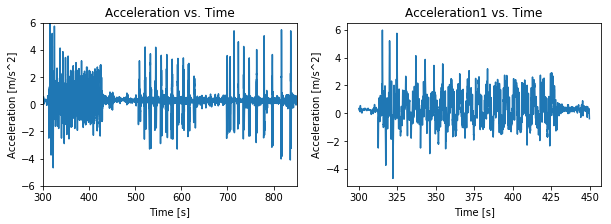

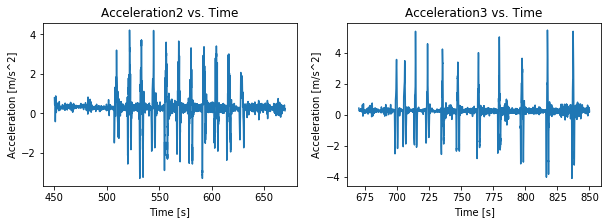

In [70]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list = []
acc_list1 = []
acc_list2 = []
acc_list3 = []

time_array = []
acc_array = []

gravity = -9.80665

#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array
time_array = time_e_array


#i = 0
#while (i < len(imu2_array)):
#    imu2_array[i] = imu2_array[i] - gravity
#    i = i + 1
#print(imu2_array)

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] > 300 and time_e_array[i] <= 450):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 450 and time_e_array[i] <= 670):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 670 and time_e_array[i] <= 850):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2


time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Acceleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_xlim([300,850])
ax1.set_ylim([-6,6])

ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
#ax2.set_ylim([-6,6])

ax3.plot(time_array2, acc_array2)
ax3.set_title("Acceleration2 vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Acceleration [m/s^2]")
#ax3.set_ylim([-6,6])

ax4.plot(time_array3, acc_array3)
ax4.set_title("Acceleration3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Acceleration [m/s^2]")
#ax4.set_ylim([-6,6])

plt.show()
    

## PSD Step 2: Detrend the data 

In [65]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

##Remove outliers--points greater than 3x the standard deviation
std1 = np.std(dacc_array1)*3
std2 = np.std(dacc_array2)*3
std3 = np.std(dacc_array3)*3

#Returns a new array that is the same as the array passed in, with its outliers removed.
def removed_outliers(a_array, time_array, std):
    i = 0
    count = 0
    ret_accs = []
    ret_times = []
    while i < (len(a_array)):
        #if smaller than std, keep that value (larger ones get removed)
        if abs(a_array[i]) < std:
            ret_accs.append(a_array[i])
            ret_times.append(time_array[i])
        else:
            count = count + 1  #could help with debugging to know how many outliers removed
        i = i + 1  
    return count, ret_accs, ret_times;
        
count1, ro_array1, ro_time1 = removed_outliers(dacc_array1, time_array1, std1)
count2, ro_array2, ro_time2 = removed_outliers(dacc_array2, time_array2, std2)
count3, ro_array3, ro_time3 = removed_outliers(dacc_array3, time_array3, std3)

#print(len(dacc_array1))
#print(count1)
#print(len(ro_array1))

##Set up data interpolation (using Cubic Splines) for use in next step
cs1 = CubicSpline(ro_time1, ro_array1)
cs2 = CubicSpline(ro_time2, ro_array2)
cs3 = CubicSpline(ro_time3, ro_array3)


##interpld returns a function that relates y=ro_array (without outliers) to x=time:
#cs1 = interp1d(ro_time1, ro_array1)
#cs2 = interp1d(ro_time2, ro_array2)
#cs3 = interp1d(ro_time3, ro_array3)

#Now, use this interpolation to put points back into the original graph:
def add_interpolated_pts(a_array, time_array, std, cs):
    i = 0
    ret_acc = []
    while i < (len(a_array)):
        if abs(a_array[i]) > std:
            ret_acc.append(cs(time_array[i]))
        else:
            ret_acc.append(a_array[i])
        i = i + 1  
    return ret_acc;


#These are the new arrays with the interpolated points (which we will
#feed into a Kalman filter later).
interp_array1 = add_interpolated_pts(dacc_array1, time_array1, std1, cs1)
interp_array2 = add_interpolated_pts(dacc_array2, time_array2, std2, cs2)
interp_array3 = add_interpolated_pts(dacc_array3, time_array3, std3, cs3)


#print(len(interp_array1))
#print(len(dacc_array1))

##To verify that the two arrays are different(i.e. pts were actually interpolated):
j = 0
count = 0
while (j < (len(interp_array1) - 1)):
    if interp_array1[j] != dacc_array1[j]:
        count = count + 1
    j = j + 1
        
#print(count)
    

## Plot all of the data, to see visually:

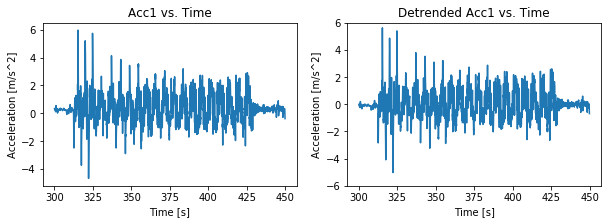

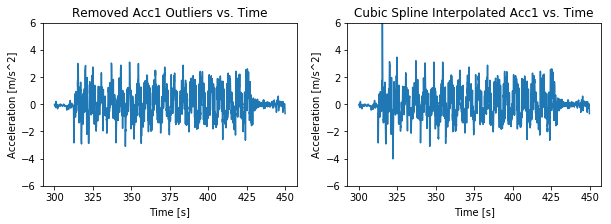

In [66]:
##Plotting the results for the 1st sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array1, acc_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
#ax1.set_ylim([-6,6])

ax2.plot(time_array1, dacc_array1)
ax2.set_title("Detrended Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

ax3.plot(ro_time1, ro_array1)
ax3.set_title('Removed Acc1 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])

ax4.plot(time_array1, interp_array1)
ax4.set_title("Cubic Spline Interpolated Acc1 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()

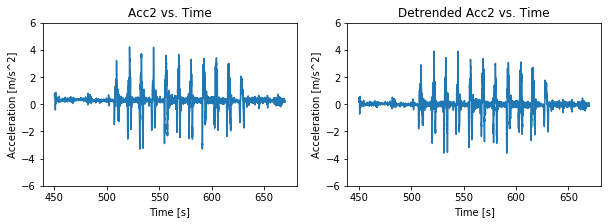

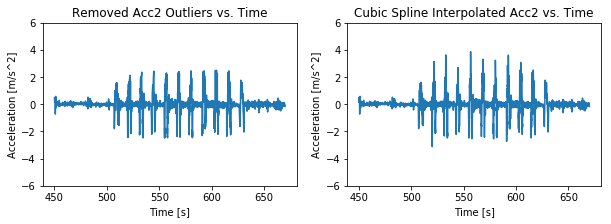

In [48]:
##Plotting the results for the 2nd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array2, acc_array2)
ax1.set_title('Acc2 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array2, dacc_array2)
ax2.set_title("Detrended Acc2 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time2, ro_array2)
ax3.set_title('Removed Acc2 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array2, interp_array2)
ax4.set_title("Cubic Spline Interpolated Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()




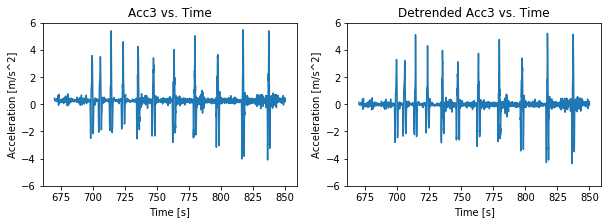

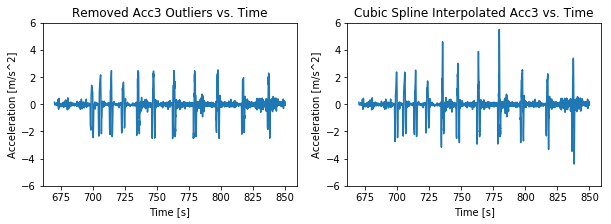

In [49]:
##Plotting the results for the 3rd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array3, acc_array3)
ax1.set_title('Acc3 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array3, dacc_array3)
ax2.set_title("Detrended Acc3 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time3, ro_array3)
ax3.set_title('Removed Acc3 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array3, interp_array3)
ax4.set_title("Cubic Spline Interpolated Acc3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()



Here, I'm implementing a lowess filter instead of a Kalman 
 filter right now because it seems simpler to implement.




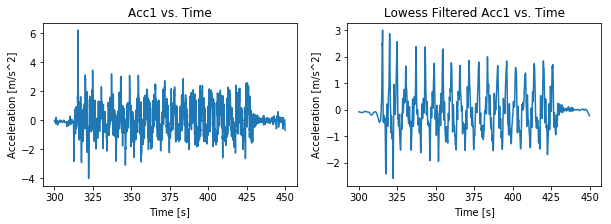

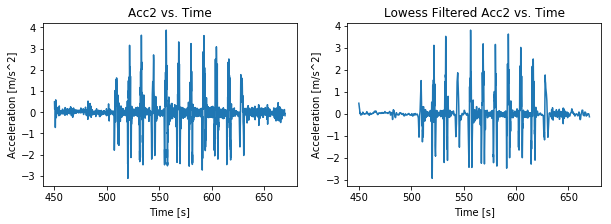

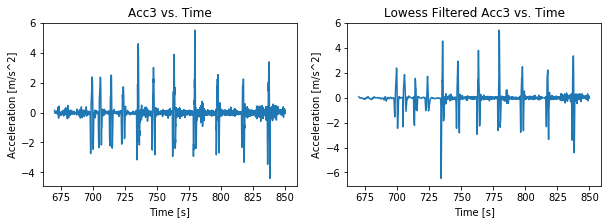

Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better 
 than the original.


In [50]:
##Now, feed interpolated arrays through a Kalman filter:
##(Actually I'm going to use a LOWESS filter for simplicity)

print("\n")
print("Here, I'm implementing a lowess filter instead of a Kalman \n filter right now because it seems simpler to implement.")
print("\n")

lowess = sm.nonparametric.lowess

#Parameters: takes in (y,x, ...)
filtered1 = lowess(interp_array1, time_array1, frac=0.005, is_sorted=True, return_sorted=False) 
filtered2 = lowess(interp_array2, time_array2, frac=0.002, is_sorted=True, return_sorted=False) 
filtered3 = lowess(interp_array3, time_array3, frac=0.002, is_sorted=True, return_sorted=False) 


##Plotting the filtered results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(time_array1, interp_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax2.plot(time_array1, filtered1)
ax2.set_title("Lowess Filtered Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc2
ax3.plot(time_array2, interp_array2)
ax3.set_title('Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(time_array2, filtered2)
ax4.set_title("Lowess Filtered Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc3
ax5.plot(time_array3, interp_array3)
ax5.set_title('Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(time_array3, filtered3)
ax6.set_title("Lowess Filtered Acc3 vs. Time")
ax6.set_xlabel("Time [s]")
ax6.set_ylabel('Acceleration [m/s^2]')

plt.show()

print("Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better \n than the original.")


## PSD Step 3: FFT of filtered data

Experiment Explanations:
Experiment1: We created 'waves' with amplitude of 1m and period of 6s.
We expect to see a peak at: 1/6s = 0.16 Hz.
Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.
We expect to see a peak at: 1/4s = 0.25 Hz.
Experiment3: We created 'waves' with amplitude of 1m and period of 2s.
We expect to see a peak at: 1/2s = 0.5. Hz.


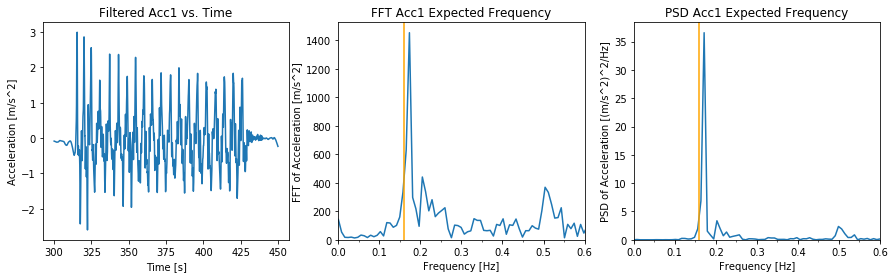

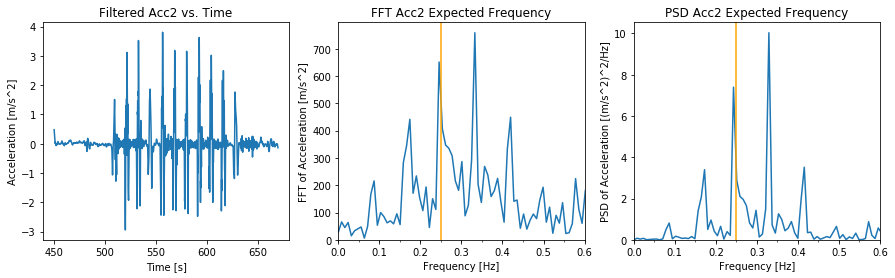

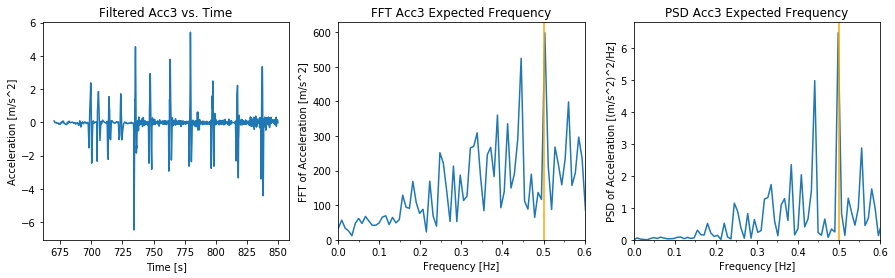

In [57]:
#First, need to fit the data so that the timestamps are *exactly* uniform

##PSD of filtered data
#psd1 = scipy.signal.periodogram(filtered1)
#psd2 = scipy.signal.periodogram(filtered2)
#psd3 = scipy.signal.periodogram(filtered3)

#These are just in case we have diff. rates later
#sampling_rate = 30
#inverse_sampling_rate = 1./sampling_rate
#timestep = inverse_sampling_rate

#For the 30Hz data we will just use timestep = 0.033
timestep = 0.033

fft1 = abs(np.fft.rfft(filtered1))
fft2 = abs(np.fft.rfft(filtered2))
fft3 = abs(np.fft.rfft(filtered3))

n1 = filtered1.size
n2 = filtered2.size
n3 = filtered3.size

fft_freq1 = np.fft.rfftfreq(n1, timestep)
fft_freq2 = np.fft.rfftfreq(n2, timestep)
fft_freq3 = np.fft.rfftfreq(n3, timestep)

#Here, we want to apply a low pass filter, and we only care about lower frequency signals (smaller than a
#frequency of 0.5 or 0.6)

#for x,y in zip(filtered1,fft1):
#    print(x)
#    print(y)

#for x in fft1:
#    print(x)

print("Experiment Explanations:")
print("Experiment1: We created 'waves' with amplitude of 1m and period of 6s.")
print("We expect to see a peak at: 1/6s = 0.16 Hz.")
print("Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.")
print("We expect to see a peak at: 1/4s = 0.25 Hz.")
print("Experiment3: We created 'waves' with amplitude of 1m and period of 2s.")
print("We expect to see a peak at: 1/2s = 0.5. Hz.")

##Calculating PSD graph:
#Can either estimate this by squaring the FFT or by using the python Periodogram function.

freq1, pxx1 = acc_psd1 = signal.periodogram(filtered1, fs=30, scaling='density')
freq2, pxx2 = acc_psd2 = signal.periodogram(filtered2, fs=30, scaling='density')
freq3, pxx3 = acc_psd3 = signal.periodogram(filtered3, fs=30, scaling='density')


#Calculate the peaks:
peak_fft1 = fft_freq1[np.argmax(fft1)]
peak_fft2 = fft_freq2[np.argmax(fft2)]
peak_fft3 = fft_freq3[np.argmax(fft3)]

peak_psd1 = freq1[np.argmax(pxx1)]
peak_psd2 = freq2[np.argmax(pxx2)]
peak_psd3 = freq3[np.argmax(pxx3)]


##Plotting the psd results:
f1 = plt.figure(figsize=(15,4))
ax1 = f1.add_subplot(131)
ax2 = f1.add_subplot(132)
ax7 = f1.add_subplot(133)

f2 = plt.figure(figsize=(15,4))
ax3 = f2.add_subplot(131)
ax4 = f2.add_subplot(132)
ax8 = f2.add_subplot(133)

f3 = plt.figure(figsize=(15,4))
ax5 = f3.add_subplot(131)
ax6 = f3.add_subplot(132)
ax9 = f3.add_subplot(133)

##Subplots for acc1
ax1.plot(time_array1, filtered1)
ax1.set_title('Filtered Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
#------------------------------
ax2.plot(fft_freq1, fft1)
ax2.set_title("FFT Acc1 Expected Frequency")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('FFT of Acceleration [m/s^2]')
ax2.set_xlim(0,0.6)
ax2.set_ylim(0,)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax2.axvline(0.16, color="orange")
#ax2.axvline(peak_fft1, color="red")
#------------------------------
ax7.plot(freq1, pxx1)
ax7.set_title("PSD Acc1 Expected Frequency")
ax7.set_xlabel("Frequency [Hz]")
ax7.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax7.set_xlim(0,0.6)
ax7.set_ylim(0,)
ax7.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax7.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax7.axvline(0.16, color="orange")
#ax7.axvline(peak_psd1, color="red")


##Subplots for acc2
ax3.plot(time_array2, filtered2)
ax3.set_title('Filtered Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(fft_freq2, fft2)
ax4.set_title("FFT Acc2 Expected Frequency")
ax4.set_xlabel("Frequency [Hz]")
ax4.set_ylabel('FFT of Acceleration [m/s^2]')
ax4.set_xlim(0,0.6)
ax4.set_ylim(0,)
ax4.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax4.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax4.axvline(0.25, color="orange")
ax8.plot(freq2, pxx2)
ax8.set_title("PSD Acc2 Expected Frequency")
ax8.set_xlabel("Frequency [Hz]")
ax8.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax8.set_xlim(0,0.6)
ax8.set_ylim(0,)
ax8.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax8.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax8.axvline(0.25, color="orange")

##Subplots for acc3
ax5.plot(time_array3, filtered3)
ax5.set_title('Filtered Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(fft_freq3, fft3)
ax6.set_title("FFT Acc3 Expected Frequency")
ax6.set_xlabel("Frequency [Hz]")
ax6.set_ylabel('FFT of Acceleration [m/s^2]')
ax6.set_xlim(0,0.6)
ax6.set_ylim(0,)
ax6.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax6.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax6.axvline(0.5, color="orange")
ax9.plot(freq3, pxx3)
ax9.set_title("PSD Acc3 Expected Frequency")
ax9.set_xlabel("Frequency [Hz]")
ax9.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax9.set_xlim(0,0.6)
ax9.set_ylim(0,)
ax9.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax9.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax9.axvline(0.5, color="orange")


plt.show()


#KaiserBessel window (based on the modified zero-order Bessel function) to reduce
#spectral leakage.

In [52]:
#Next steps: Noise-correct acceleration spectra
#1. Kaiser Bessel Window before FFT, and then post-processing of data
#2. Frequency Domain Filter to acceleration spectra to remove low-frequency noise
#   (modification of empirical noise correction of Lang 1987)





## Displacement Spectra:

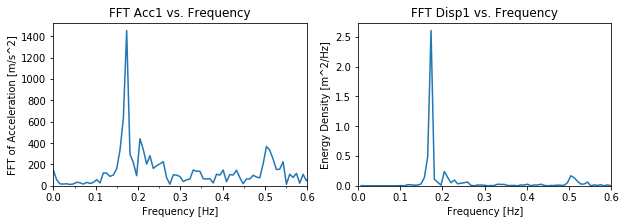

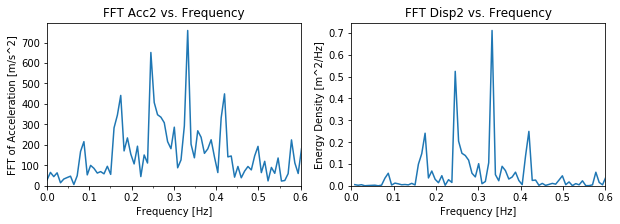

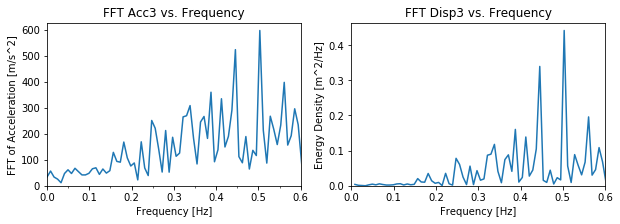

In [53]:
##Noise-corrected Acceleration spectra converted to displacement
##spectra by dividing by the frequency to the fourth power.

##Check to see if they're the same length:
#print(len(fft3))
#print(len(fft_freq3))

#for x in fft_freq3:
#    print(x**4)
    
##First attempt:   
##Iterate over the fft and freq lists to calculate new displacement spectra values.
samp_freq = 30

def calc_disp(fft, freq):
    fft = fft[1:] #Get rid of the first value, since fft_freq's first value is 0, and cannot divide by zero.
    freq = freq[1:]
    disp_spectra = []
    for x_fft, y_freq in zip(fft, freq):
        #"Normalizing" the PSD?
        new_d = float(x_fft**2/(samp_freq**4)) #Need to divide by 30**4 bc sampling freq?
        #new_d = float(x_fft/(y_freq**4)) #Using y_freq doesn't work
        #print(new_d)
        #print(y_freq)
        disp_spectra.append(new_d)
    return disp_spectra, freq

disp_spectra1, fft_nfreq1 = calc_disp(fft1, fft_freq1)
disp_spectra2, fft_nfreq2 = calc_disp(fft2, fft_freq2)
disp_spectra3, fft_nfreq3 = calc_disp(fft3, fft_freq3)



##Second attempt:

def calc_disp2(fft, freq):
    fft = fft[1:] #Get rid of the first value, since fft_freq's first value is 0, and cannot divide by zero.
    freq = freq[1:]
    disp_spectra = []
    for x_fft, y_freq in zip(fft, freq):
        omega = 2*math.pi*y_freq
        #new_d = float(x_fft/omega**2) #for FFT?
        new_d = float(x_fft/omega**4) #for PSD?
        disp_spectra.append(new_d)
    return disp_spectra, freq

#disp_spectra1, fft_nfreq1 = calc_disp2(fft1, fft_freq1)
#disp_spectra2, fft_nfreq2 = calc_disp2(fft2, fft_freq2)
#disp_spectra3, fft_nfreq3 = calc_disp2(fft3, fft_freq3)

##Attempt using PSD instead of FFT:
#disp_spectra1, fft_nfreq1 = calc_disp2(pxx1, freq1)
#disp_spectra2, fft_nfreq2 = calc_disp2(pxx2, freq2)
#disp_spectra3, fft_nfreq3 = calc_disp2(pxx3, freq3)



#for x in disp_spectra1:
#    print(x)
    
    
#for x,y in zip(disp_spectra1, fft_nfreq1):
#    print(x,y)


#disp_spectra1 = np.array(disp_spectra1)

##Plotting the psd results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(fft_freq1, fft1)
ax1.set_title("FFT Acc1 vs. Frequency")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel('FFT of Acceleration [m/s^2]')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,)
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.05))

ax2.plot(fft_nfreq1, disp_spectra1)
ax2.set_title('FFT Disp1 vs. Frequency')
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('Energy Density [m^2/Hz]')
ax2.set_xlim(0,0.6)
ax2.set_ylim(0,)


##Subplots for acc2
ax3.plot(fft_freq2, fft2)
ax3.set_title("FFT Acc2 vs. Frequency")
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel('FFT of Acceleration [m/s^2]')
ax3.set_xlim(0,0.6)
ax3.set_ylim(0,)
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax4.plot(fft_nfreq2, disp_spectra2)
ax4.set_title('FFT Disp2 vs. Frequency')
ax4.set_xlabel("Frequency [Hz]")
ax4.set_ylabel('Energy Density [m^2/Hz]')
ax4.set_xlim(0,0.6)
ax4.set_ylim(0,)

##Subplots for acc3
ax5.plot(fft_freq3, fft3)
ax5.set_title("FFT Acc3 vs. Frequency")
ax5.set_xlabel("Frequency [Hz]")
ax5.set_ylabel('FFT of Acceleration [m/s^2]')
ax5.set_xlim(0,0.6)
ax5.set_ylim(0,)
ax5.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax5.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax6.plot(fft_nfreq3, disp_spectra3)
ax6.set_title('FFT Disp3 vs. Frequency')
ax6.set_xlabel("Frequency [Hz]")
ax6.set_ylabel('Energy Density [m^2/Hz]')
ax6.set_xlim(0,0.6)
ax6.set_ylim(0,)

plt.show()

## Calculating Wave Statistics:

In [54]:
#Print out the peak wave period: get the x-axis value at the peak y-axis value
peak_freq1 = fft_nfreq1[np.argmax(disp_spectra1)]
peak_freq2 = fft_nfreq2[np.argmax(disp_spectra2)]
peak_freq3 = fft_nfreq3[np.argmax(disp_spectra3)]

print("Calculating Peak Frequency:")
print("Expected near 0.16 Hz and got: ", peak_freq1, "Hz")
print("Expected near 0.25 Hz and got: ", peak_freq2, "Hz")
print("Expected near 0.5 Hz and got: ", peak_freq3, "Hz")


#Print out the peak wave frequency, which is 1/peak_period
peak_period1 = 1/peak_freq1
peak_period2 = 1/peak_freq2
peak_period3 = 1/peak_freq3

print("\n")
print("Calculating Peak Period:")
print("Expected near 6 secs and got: ", peak_period1, "secs")
print("Expected near 4 secs  and got: ", peak_period2, "secs")
print("Expected near 2 secs and got: ", peak_period3, "secs")

##Calculate the mean variance of the sea surface elevation, by taking the integral under the FFT curve
#We only want to integrate while fft_nfreq < 0.6:

def limit_frequency_range(fft_freq):
    ret_freq = []
    for x in fft_freq:
        if x < 0.6:
            ret_freq.append(x)
    return ret_freq

lim_freq1 = limit_frequency_range(fft_nfreq1)
lim_freq2 = limit_frequency_range(fft_nfreq2)
lim_freq3 = limit_frequency_range(fft_nfreq3)

#Need to make disp_spectra match length of newly limited frequency:
len1 = len(lim_freq1)
len2 = len(lim_freq2)
len3 = len(lim_freq3)

lim_dspectra1 = disp_spectra1[0:len1]
lim_dspectra2 = disp_spectra2[0:len2]
lim_dspectra3 = disp_spectra3[0:len3]

m0_1 = simps(y=lim_dspectra1, x=lim_freq1)
m0_2 = simps(y=lim_dspectra2, x=lim_freq2)
m0_3 = simps(y=lim_dspectra3, x=lim_freq3)

Hs1 = 4*math.sqrt(m0_1)
Hs2 = 4*math.sqrt(m0_2)
Hs3 = 4*math.sqrt(m0_3)

print("\n")
print("Calculating Significant Wave Heights:")
print("Expecting near 1m and got: ", Hs1, "[m]")
print("Expecting near 1.5m and got: ", Hs2, "[m]")
print("Expecting near 1m and got: ", Hs3, "[m]")


#Calculate the significant wave height by taking 4*sqrt(mean_variance^2)

Calculating Peak Frequency:
Expected near 0.16 Hz and got:  0.173205161514 Hz
Expected near 0.25 Hz and got:  0.332652188376 Hz
Expected near 0.5 Hz and got:  0.503262959021 Hz


Calculating Peak Period:
Expected near 6 secs and got:  5.7735 secs
Expected near 4 secs  and got:  3.00614285714 secs
Expected near 2 secs and got:  1.98703278689 secs


Calculating Significant Wave Heights:
Expecting near 1m and got:  0.8048442181065127 [m]
Expecting near 1.5m and got:  0.7292276264888505 [m]
Expecting near 1m and got:  0.64979604029525 [m]
